In [2]:
import numpy as np
import pandas as pd

import astropy.units as u
import astropy.constants as c
import datetime

In [3]:
"MATPLOTLIB"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import matplotlib.lines as lines

mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

In [11]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(2*u.min).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    time=pd.to_datetime(dl.date)
    dt=(time.iloc[1]-time.iloc[0]).total_seconds()*u.s # time increment in dl
    lon=(dl.lonR.to_numpy())*u.deg.to(u.rad) # sub-radar longitude to radians
    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    x=np.sin(lat)*np.cos(lon) # unit vector coord x
    y=np.sin(lat)*np.sin(lon) # unit vector coord y
    z=np.cos(lat) # unit vector coord z
    pointing=np.vstack((x,y,z)).T # unit vector of subradar pointing
    dtheta=np.arccos((pointing[1:]*pointing[:-1]).sum(axis=1)) # change in angle from moment to moment
    omega=dtheta/dt # angular frequency
    period=2*np.pi/omega # return rotation period
    rotfreq=1/period # rotation frequency
    phi=lat[1:] # subradar latitude
    bw=4*np.pi*np.cos(phi)*370*u.m/((c.c/freq)*period) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*np.sqrt(bw/tau)) # rms noise power (Eq. D)
    SNR=(Prx[1:]/Nrms).si # return signal-to-noise ratio 
    return PrxdB, Pratio, SNR, omega, nametx,namerx

def power_plots(PrxdB, Pratio, SNR, omega, nametx,namerx,df,tx,rx):
    title='TX: '+nametx+'; RX: '+namerx

    savefigs = False
    # dBm plot
    plt.figure(dpi=150)
    plt.plot(df.datetime_jd-df.datetime_jd.min(),PrxdB)
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("Prx (dBm)")
    if savefigs: plt.savefig('../Figures/German/dBm'+tx+'_'+rx+'.png')
    plt.title(title)
    plt.show()
    # Power ratio plot
    plt.figure(dpi=150)
    plt.semilogy(df.datetime_jd-df.datetime_jd.min(),Pratio)
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("Prx/Ptx ")
    if savefigs: plt.savefig('../Figures/German/Pratio'+tx+'_'+rx+'.png')
    plt.title(title)
    plt.show()

    # SNR plot
    plt.figure(dpi=150)
    plt.semilogy((df.datetime_jd-df.datetime_jd.min())[1:],SNR)
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("SNR")
    if savefigs: plt.savefig('../Figures/German/SNR'+tx+'_'+rx+'.png')
    plt.title(title)
    plt.show()

    # rotation period plot
    plt.figure(dpi=150)
    plt.plot((df.datetime_jd-df.datetime_jd.min())[1:],(omega*(180/np.pi)).to(u.h**-1))
    plt.xlabel("JD-"+str(df.datetime_jd.min()))
    plt.ylabel("Angular frequency (deg/hour)")
    if savefigs: plt.savefig('../Figures/German/angfreq.png') # the same for all telescope pairs
    plt.title(title)
    plt.show()

In [5]:
df=pd.read_csv("../Data/observatory_distances_indexes.csv")
rtdb=pd.read_csv('../AllRadiotelescopes.csv')
dl=pd.read_csv('../Data/subradar_points.csv')

ephemeris = pd.read_csv("../ephemeris2.csv")
ephemeris['hours'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])
MIN = ephemeris['delta (Rt)'].argmin()

In [6]:
print([i for i in rtdb.Code])

['ARE', 'GOL', 'GBT', 'VLA', 'FAS', 'CDS', 'ECD', 'USU', 'EFE', 'LOV', 'MDS', 'PRK', 'AVN']


In [7]:
pairs = [
    ('CDS','PRK'),
    ('MDS','LOV'),
    ('MDS','AVN'),
    ('MDS','EFE'),
    ('GOL','GBT'),
    ('GOL','GBT'),
    ('ARE','GBT'),
]


TypeError: can't multiply sequence by non-int of type 'float'

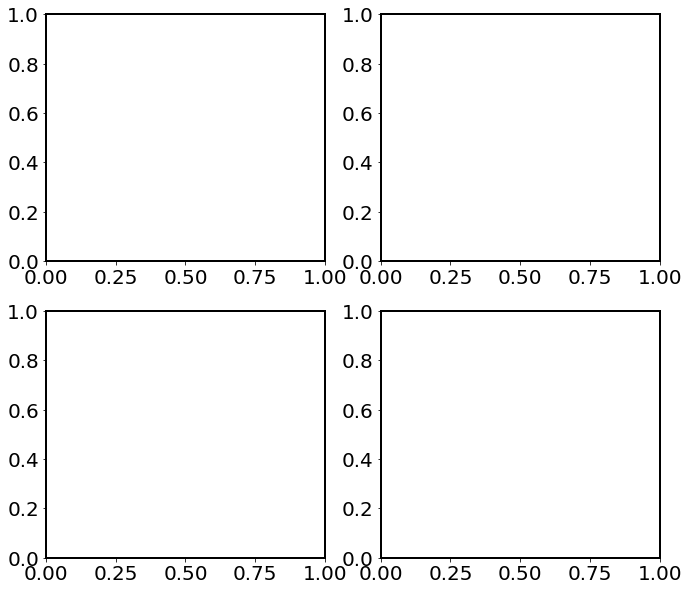

In [12]:
def x_axis(ax,i):
    ax.grid()
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][i] for i in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UT (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])

    # if i == 3:
    #     ax.legend(fontsize=15)

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-']
    
    i = 0
    ax = axes[i]
    # dBm plot
    ax.plot(ephemeris['hours'],PrxdB,styles[n],lw=3,markevery=10,ms=10)
    ax.set_title("Reception Power (Prx)")
    ax.set_ylabel("Prx (dBm)")
    x_axis(ax,i)    

    i += 1
    ax = axes[i]
    # Power ratio plot
    ax.semilogy(ephemeris['hours'],Pratio,styles[n],lw=3,markevery=10,ms=10)
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # SNR plot
    ax.semilogy(ephemeris['hours'][1:],SNR,styles[n],lw=3,markevery=10,ms=10)
    ax.set_title("SNR")
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)

fig, axes = plt.subplots(2,2,figsize=(11,10))

# for ax in axes.flat:
#     ax.set_prop_cycle(plt.cycler('color', plt.cm.nipy_spectral(np.linspace(0.1,0.9,5)**2)))
# fig.suptitle("Reception (rx) and Transmission (tx) Radar Power")

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes.flat, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1
    ax = axes.flat[-1]
handles, labels = axes.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right",fontsize=16, labelspacing=1.2, \
    bbox_to_anchor=(0.45, 0.09, 0.5, 0.5), fancybox=False, edgecolor=(0,0,0))
fig.delaxes(axes.flat[-1])
fig.tight_layout()

# name = "../Figures/fig6_radio"
# plt.savefig(name+".pdf",bbox_inches='tight')
# plt.savefig(name+".png",bbox_inches='tight')